# Example in fibroblast sample

This example dataset is from the [cadelino paper](https://www.biorxiv.org/content/early/2018/11/26/413047) and included the [cardelino R package](https://github.com/PMBio/cardelino), and also in the fibroblast folder here.

```{r}
library(cardelino)
data("example_donor")
```

The single-cell RNA-seq data is highly sparse, and an implementation supporting sparse matrix largely reduce computation resources.

## Load data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from scmc.models.scmc_model import scmc, generate_reads, sample_Sigma

In [59]:
from scipy.io import mmread
from scipy.sparse import csr_matrix

Config = np.genfromtxt("fibroblast/SNV_clone_id.tsv", skip_header=1)

A_input = mmread("fibroblast/A_snv.mtx")
A_input = csr_matrix(A_input)

D_input = mmread("fibroblast/A_snv.mtx")
D_input = csr_matrix(D_input)

A_input
D_input

<34x428 sparse matrix of type '<class 'numpy.int64'>'
	with 581 stored elements in Compressed Sparse Row format>

In [92]:
A = A_input.toarray()
D = D_input.toarray()
print(np.mean(A > 0), np.mean(D > 0))

0.0399257833975 0.0399257833975


In [49]:
A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## Running scmc

In [45]:
d, n = A_input.shape # n_SNV and n_cells

# inverse Wishart prior
Lambda = np.eye(d) * 5 # scale matrix 
v = d # degrees of freedom

# beta prior
alpha = 3 * np.ones(d+1)
beta = 3 * np.ones(d+1)
alpha[0] = 0.3
beta[0] = 29.7

In [46]:
alpha / (alpha + beta)

array([ 0.01,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,
        0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,
        0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,
        0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ])

In [50]:
[theta_hat, Sigma_hat, X_hat] = scmc(A, D, Lambda, v, alpha, beta, max_iter=1000)

100
200
300
400
500
600
700
800
900


## Visualise covariance matrix
Group of SNVs have been observed, but seems not matched well with the clonal structure inferred from exome-seq by Canopy

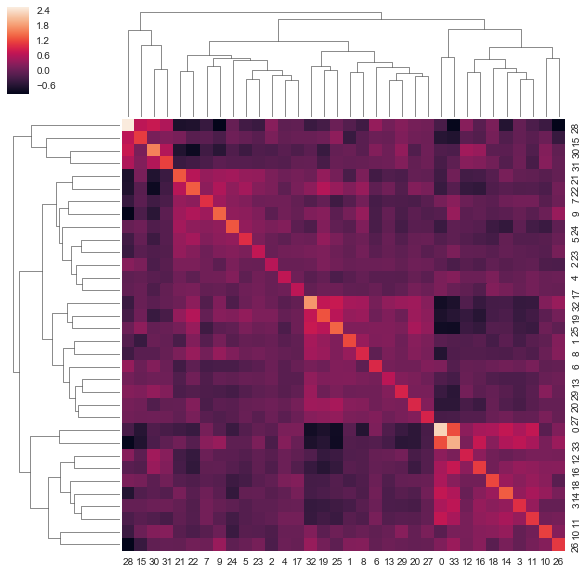

In [64]:
import seaborn as sns; sns.set(color_codes=True)
g = sns.clustermap(Sigma_hat)
plt.show()

In [101]:
print("M1:", snv_order[snv_clone_id==2])
print("M2:", snv_order[snv_clone_id==4])
print("M3:", snv_order[snv_clone_id==8])
print("M4:", snv_order[snv_clone_id==12])
print("M5:", snv_order[snv_clone_id==14])

M1: [18 32  0  4 15 10  1 30  6 21 26]
M2: [16 19 23 33]
M3: [28 20  8 13 31 27 11 22 24 25  7  3]
M4: [ 5 17 29 12  9]
M5: [14  2]


## Ordered by clonal structure infered by Canopy
The pattern is not clearly overlapped with the clonal structure, although the ordering of SNV in each mutation can be optimised.

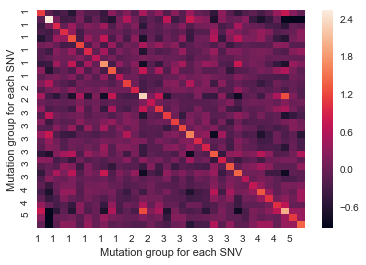

In [97]:
snv_clone_id = np.dot(Config, [1, 2, 4, 8])
snv_order = np.argsort(snv_clone_id)

snv_id = np.array([0] * 34)
snv_id[snv_clone_id == 2] = 1
snv_id[snv_clone_id == 4] = 2
snv_id[snv_clone_id == 8] = 3
snv_id[snv_clone_id == 12] = 4
snv_id[snv_clone_id == 14] = 5

g = sns.heatmap(Sigma_hat[snv_order, :][:, snv_order])
plt.xticks(np.arange(0, 34, 2), snv_id[snv_order][np.arange(0, 34, 2)])
plt.yticks(np.arange(0, 34, 2), snv_id[snv_order][np.arange(0, 34, 2)])
plt.xlabel("Mutation group for each SNV")
plt.ylabel("Mutation group for each SNV")
plt.show()